### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-30 13:02:28--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-11-30 13:02:28 (10.7 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 58, 50, ..., 45, 52, 48],
       [83, 59, 47, ..., 45, 55,  1],
       [83, 51, 50, ..., 59, 63, 68],
       ...,
       [83, 66,  2, ...,  1, 59, 81],
       [83,  1, 55, ..., 51, 50,  5],
       [83,  1, 57, ..., 40, 40, 38]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import torch.optim as optim

In [12]:
epochs = 20000
seq_length = 100
hidden_size = 100
vocab_size = num_tokens
learning_rate = 1e-3
n_layers =1

$vs$ - vocabulary size

$hs$ - hidden size

$x_t\in R^{vs}$

$h_t \in R^{hs}$

$V \in R^{vc*hs}$

$W \in R^{hs*hs}$

$U \in R^{hs*vs}$

$b \in R^{hs}$

$c \in R^{vs}$


$h^{(t)}(t)=tanh(b+W*h^{(t-1)}+U * x^{(t)})$

$y^{(t)}=softmax(c+V*h^{(t)})$

In [20]:
class RNN:
    def __init__(self, hidden_size, vocab_size, seq_length, learning_rate, U=None, V=None, W=None, b=None, c=None):
        """
        :param hidden_size:
        :param vocab_size: count characters in dictionary
        :param seq_length: length of sequence of characters
        :param learning_rate: learning rate
        :param U: [hidden_size, vocab_size]
        :param W: [hidden_size, hidden_size]
        :param V: [vocab_size, hidden_size]
        :param b: [hidden_size, 1]
        :param c: [vocab_size, 1]
        """
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        self.U = U if U is not None else np.random.uniform(-np.sqrt(1./vocab_size), np.sqrt(1./vocab_size), (hidden_size, vocab_size)) * 0.01
        self.V = V if V is not None else np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (vocab_size, hidden_size)) * 0.01
        self.W = W if W is not None else np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size)) * 0.01
        self.b = b if b is not None else np.zeros((hidden_size, 1))
        self.c = U if U is not None else np.zeros((vocab_size, 1))
        self.mU, self.mW, self.mV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        self.mb, self.mc = np.zeros_like(self.b), np.zeros_like(self.c)
        self._smooth_loss = -np.log(1./vocab_size) * seq_length

    def forward(self, inputs, h_prev):
        """
        :param inputs: [seq_len]
        :param h_prev: [hidden_size]
        :return xs: {seq_len, vocab_size}
        :return hs: {seq_len + 1, hidden_size}
        :return ycap: {seq_len, vocab_size}
        """
        xs, hs, os, ycap = {}, {}, {}, {}
        hs[-1] = np.copy(h_prev)
        for t in np.arange(len(inputs)): # iterate throw batch
            xs[t] = np.zeros((self.vocab_size, 1))
            xs[t][inputs[t]] = 1 # one-hot vector
            hs[t] = np.tanh(self.b + self.W @ hs[t-1] + self.U @ xs[t]) # hidden state
            os[t] = self.c + self.V @ hs[t]
            ycap[t] = self.softmax(os[t]) # probs
        return xs, hs, ycap

    def softmax(self, x, temperature=1):
        """
        Compute the softmax with temperature of vector x in a numerically stable way
        :param x: [seq_len]
        :param temperature: float
        :return softmax(x): [seq_len]
        """
        if temperature != 1:
            x /= temperature
        p = np.exp(x - np.max(x))
        return p / np.sum(p)

    def loss(self, ps, targets, eps=1e-8):
        """
        Calculate cross-entropy loss
        :param ps: [seq_length, vocab_size]
        :param targets: [seq_length]
        :return loss: float
        """
        loss = - np.sum([np.log(ps[i][y]+ eps) for i, y in enumerate(targets)], axis=0)
        return loss / self.seq_length

    def backward(self, xs, hs, ycap, targets):
        """
        :param xs: {seq_length, vocab_size}
        :param hs: {seq_length + 1, hidden_size}
        :param ycap: {seq_length, vocab_size}
        :param targets: [seq_length]
        :return dU: [hidden_size, vocab_size]
        :return dW: [hidden_size, hidden_size]
        :return dV: [vocab_size, hidden_size]
        :return db: [hidden_size, 1]
        :return dc: [vocab_size, 1]
        """
        dU, dW, dV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        db, dc =  np.zeros_like(self.b), np.zeros_like(self.c)
        dh_next = np.zeros_like(hs[0])
        for t in reversed(np.arange(self.seq_length)):
            dy = np.copy(ycap[t])
            dy[targets[t]] -= 1
            dV += dy @ hs[t].T
            dc += dy
            dh = self.V.T @ dy + dh_next
            dh_rec = (1 - hs[t-1]**2) * dh
            db += dh_rec
            dU += dh_rec @ xs[t].T
            dW += dh_rec @ hs[t-1].T
            dh_next = self.W.T @ dh_rec
        for dparam in [dU, dW, dV, db, dc]:
            np.clip(dparam, -5, 5, out=dparam)
        return dU, dW, dV, db, dc


    def update_model(self, dU, dW, dV, db, dc, ps, targets):
        """
        Updates parameters of model: self.U, self.W, self.V, self.b, self.c
        param <- param - self.lr * grad(param)
        :param dU: [hidden_size, vocab_size]
        :param dW: [hidden_size, hidden_size]
        :param dV: [vocab_size, hidden_size]
        :param db: [hidden_size, 1]
        :param dc: [vocab_size, 1]
        """
        loss = self.loss(ps, targets)
        self._smooth_loss = self._smooth_loss * 0.999 + loss * 0.001
        for param, dparam, mem in zip([self.U, self.W, self.V, self.b, self.c],
                                      [dU, dW, dV, db, dc],
                                      [self.mU, self.mW, self.mV, self.mb, self.mc]):
            mem += dparam * dparam
            param -= self.learning_rate * dparam / np.sqrt(mem + 1e-8)
        return loss

    def train(self, epochs, generate_chunk):
        loss_history = []
        for epoch in tqdm(np.arange(epochs)):
            chunk = next(generate_chunk())
            batch_size = chunk.shape[0]
            inputs = chunk[:, :-1]
            targets = chunk[:, 1:]
            h_prev = np.zeros((self.hidden_size, 1))
            for batch in np.arange(batch_size):
                xs, hs, ycap = self.forward(inputs[batch], h_prev)
                ps = np.array([ycap[t] for t in np.arange(self.seq_length)])
                dU, dW, dV, db, dc = self.backward(xs, hs, ycap, targets[batch])
                loss = self.update_model(dU, dW, dV, db, dc, ps, targets[batch])
                loss_history.append(loss)
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss[-1]}')
        return loss_history


    def predict(self, token_to_idx, idx_to_token, start, n):
        """
        :param data_reader: [hidden_size, vocab_size]
        :param start: start sequence of text (string)
        :param n: length of predicted text (int)
        :return txt: [hidden_size, 1]
        """
        x = np.zeros((self.vocab_size, 1))
        chars = [ch for ch in start]
        ixes = []
        for i in np.arange(len(chars)):
            ix = token_to_idx[chars[i]]
            x[ix] = 1
            ixes.append(ix)
        h = np.zeros((self.hidden_size, 1))
        for t in np.arange(n):
            h = np.tanh(self.U @ x + self.W @ h + self.b)
            y = self.V @ h + self.c
            p = self.softmax(y)
            ix = np.random.choice(np.arange(self.vocab_size), p=p.ravel())
            x[ix] = 1
            ixes.append(ix)
        txt = ''.join(idx_to_token[i] for i in ixes)
        return txt

In [23]:
rnn = RNN(hidden_size, vocab_size, seq_length, learning_rate)
loss_history = rnn.train(epochs, generate_chunk)

  9%|▉         | 1/11 [00:07<01:14,  7.45s/it]

Epoch 0/11, Loss: 2.93115054590796


100%|██████████| 11/11 [01:37<00:00,  8.84s/it]

Epoch 10/11, Loss: 2.564628109180725


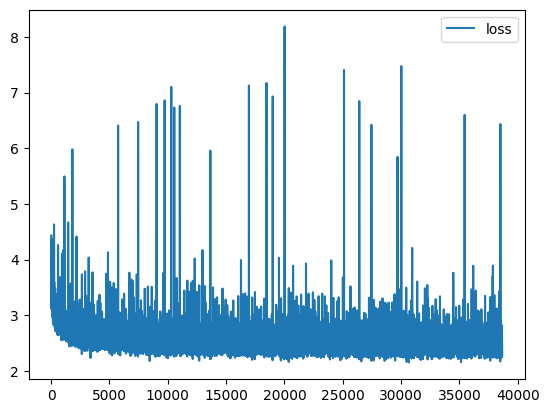

In [36]:
plt.plot(loss_history, label='loss')
plt.legend()

In [26]:
rnn.predict(token_to_idx, idx_to_token, ' мой дядя самых честных правил', n=500)

' мой дядя самых честных правилеооееоаыесаеееараюе?ет…ерсяььн ь  ,л  н  ,ь ,н,   ч     е  неанн и   ея    и  \nт\nе .     м      ;  ,        \n   \n   \n   \n      \n                  т \nн\n \n \n \n   нн \n\n   \n  \nт\n \n  ,\n \n\n             \n   \n   л     с н  х  \n   \n \n  \n \n\n              \n   \n ,\n  \n \n  \n    \n,       \n       \n    , \n\n,\n\n , \n      \n ,       \n\n   \n   \n          \n.   \n        \n    \n    \n  \n н  \n  жы, ,  !ь \n   \n \n  \n    \nн  \n\n\n  \n  \n  \n   \n   \n\n\n  \n\n          , \n\n ,       \n\n   \n   ,\n  \n    \n   ,   ,      \n\n,   \n  \n \n :\n  \n   '

In [13]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout=0.5):
        super(VanillaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.loss_history = None
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

    def train_model(self, epochs, batch_size, criterion, optimizer):
        self.train()
        loss_history = []
        for e in tqdm(np.arange(epochs), desc="Training Epochs"):
            hidden = self.init_hidden(batch_size)
            chunk = next(generate_chunk())
            inputs = torch.nn.functional.one_hot(torch.tensor(chunk[:, :-1]), num_classes=num_tokens).float()
            targets = torch.tensor(chunk[:,1:]).reshape(-1)
            optimizer.zero_grad()
            outputs, hiddens = self(inputs, hidden)
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            loss_history.append(loss.item())
            loss.backward()
            optimizer.step()
            if e % 100 == 0:
                print(f'Epoch [{e + 1}/{epochs}], Loss: {loss_history[-1]:.4f}')
        self.loss_history = loss_history

In [ ]:
model = VanillaRNN(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train_model(epochs, batch_size, criterion, optimizer)

Training Epochs:   0%|          | 1/20000 [00:00<2:11:29,  2.53it/s]

Epoch [1/20000], Loss: 4.5389


Training Epochs:   1%|          | 101/20000 [00:28<1:29:44,  3.70it/s]

Epoch [101/20000], Loss: 2.6306


Training Epochs:   1%|          | 201/20000 [00:56<1:27:51,  3.76it/s]

Epoch [201/20000], Loss: 2.5186


Training Epochs:   2%|▏         | 301/20000 [01:25<1:26:29,  3.80it/s]

Epoch [301/20000], Loss: 2.3797


Training Epochs:   2%|▏         | 401/20000 [01:53<1:47:56,  3.03it/s]

Epoch [401/20000], Loss: 2.3179


Training Epochs:   3%|▎         | 501/20000 [02:21<1:30:26,  3.59it/s]

Epoch [501/20000], Loss: 2.2947


Training Epochs:   3%|▎         | 601/20000 [02:49<1:24:06,  3.84it/s]

Epoch [601/20000], Loss: 2.2354


Training Epochs:   4%|▎         | 701/20000 [03:17<1:27:36,  3.67it/s]

Epoch [701/20000], Loss: 2.2143


Training Epochs:   4%|▍         | 801/20000 [03:44<1:26:03,  3.72it/s]

Epoch [801/20000], Loss: 2.1673


Training Epochs:   5%|▍         | 901/20000 [04:13<1:51:06,  2.87it/s]

Epoch [901/20000], Loss: 2.1365


Training Epochs:   5%|▌         | 1001/20000 [04:41<1:21:50,  3.87it/s]

Epoch [1001/20000], Loss: 2.1222


Training Epochs:   6%|▌         | 1101/20000 [05:08<1:22:23,  3.82it/s]

Epoch [1101/20000], Loss: 2.0581


Training Epochs:   6%|▌         | 1201/20000 [05:36<1:20:39,  3.88it/s]

Epoch [1201/20000], Loss: 2.0690


Training Epochs:   7%|▋         | 1301/20000 [06:03<1:23:07,  3.75it/s]

Epoch [1301/20000], Loss: 2.0283


Training Epochs:   7%|▋         | 1401/20000 [06:31<1:52:41,  2.75it/s]

Epoch [1401/20000], Loss: 2.0095


Training Epochs:   8%|▊         | 1501/20000 [06:59<1:23:43,  3.68it/s]

Epoch [1501/20000], Loss: 1.9865


Training Epochs:   8%|▊         | 1601/20000 [07:27<1:20:45,  3.80it/s]

Epoch [1601/20000], Loss: 2.0113


Training Epochs:   9%|▊         | 1701/20000 [07:54<1:21:35,  3.74it/s]

Epoch [1701/20000], Loss: 1.9749


Training Epochs:   9%|▉         | 1801/20000 [08:22<1:34:31,  3.21it/s]

Epoch [1801/20000], Loss: 1.9382


Training Epochs:  10%|▉         | 1901/20000 [08:51<1:24:54,  3.55it/s]

Epoch [1901/20000], Loss: 2.0493


Training Epochs:  10%|█         | 2001/20000 [09:19<1:18:18,  3.83it/s]

Epoch [2001/20000], Loss: 1.9684


Training Epochs:  11%|█         | 2101/20000 [09:47<1:17:20,  3.86it/s]

Epoch [2101/20000], Loss: 1.9730


Training Epochs:  11%|█         | 2201/20000 [10:14<1:16:33,  3.88it/s]

Epoch [2201/20000], Loss: 1.9017


Training Epochs:  12%|█▏        | 2301/20000 [10:42<1:38:45,  2.99it/s]

Epoch [2301/20000], Loss: 1.9684


Training Epochs:  12%|█▏        | 2401/20000 [11:10<1:17:15,  3.80it/s]

Epoch [2401/20000], Loss: 1.8724


Training Epochs:  13%|█▎        | 2501/20000 [11:38<1:19:06,  3.69it/s]

Epoch [2501/20000], Loss: 1.9006


Training Epochs:  13%|█▎        | 2601/20000 [12:06<1:18:50,  3.68it/s]

Epoch [2601/20000], Loss: 1.9057


Training Epochs:  14%|█▎        | 2701/20000 [12:34<1:16:01,  3.79it/s]

Epoch [2701/20000], Loss: 1.8521


Training Epochs:  14%|█▍        | 2801/20000 [13:02<1:25:11,  3.36it/s]

Epoch [2801/20000], Loss: 1.8607


Training Epochs:  15%|█▍        | 2901/20000 [13:30<1:16:33,  3.72it/s]

Epoch [2901/20000], Loss: 1.8270


Training Epochs:  15%|█▌        | 3001/20000 [13:58<1:15:18,  3.76it/s]

Epoch [3001/20000], Loss: 1.9550


Training Epochs:  16%|█▌        | 3101/20000 [14:26<1:13:36,  3.83it/s]

Epoch [3101/20000], Loss: 1.8610


Training Epochs:  16%|█▌        | 3201/20000 [14:55<1:40:25,  2.79it/s]

Epoch [3201/20000], Loss: 1.8428


Training Epochs:  17%|█▋        | 3301/20000 [15:22<1:17:28,  3.59it/s]

Epoch [3301/20000], Loss: 1.8379


Training Epochs:  17%|█▋        | 3401/20000 [15:50<1:13:26,  3.77it/s]

Epoch [3401/20000], Loss: 1.8492


Training Epochs:  18%|█▊        | 3501/20000 [16:18<1:11:59,  3.82it/s]

Epoch [3501/20000], Loss: 1.8337


Training Epochs:  18%|█▊        | 3601/20000 [16:46<1:11:54,  3.80it/s]

Epoch [3601/20000], Loss: 1.8433


Training Epochs:  19%|█▊        | 3701/20000 [17:14<1:22:13,  3.30it/s]

Epoch [3701/20000], Loss: 1.8276


Training Epochs:  19%|█▉        | 3801/20000 [17:44<1:13:04,  3.69it/s]

Epoch [3801/20000], Loss: 1.7962


Training Epochs:  20%|█▉        | 3901/20000 [18:13<1:15:42,  3.54it/s]

Epoch [3901/20000], Loss: 1.7989


Training Epochs:  20%|██        | 4001/20000 [18:42<1:36:16,  2.77it/s]

Epoch [4001/20000], Loss: 1.8225


Training Epochs:  21%|██        | 4101/20000 [19:11<1:11:52,  3.69it/s]

Epoch [4101/20000], Loss: 1.7910


Training Epochs:  21%|██        | 4201/20000 [19:39<1:08:32,  3.84it/s]

Epoch [4201/20000], Loss: 1.7842


Training Epochs:  22%|██▏       | 4301/20000 [20:08<1:09:52,  3.74it/s]

Epoch [4301/20000], Loss: 1.8313


Training Epochs:  22%|██▏       | 4401/20000 [20:37<1:34:38,  2.75it/s]

Epoch [4401/20000], Loss: 1.7784


Training Epochs:  23%|██▎       | 4501/20000 [21:05<1:10:09,  3.68it/s]

Epoch [4501/20000], Loss: 1.7509


Training Epochs:  23%|██▎       | 4601/20000 [21:33<1:09:08,  3.71it/s]

Epoch [4601/20000], Loss: 1.7758


Training Epochs:  24%|██▎       | 4701/20000 [22:01<1:07:01,  3.80it/s]

Epoch [4701/20000], Loss: 1.7471


Training Epochs:  24%|██▍       | 4801/20000 [22:30<1:26:00,  2.95it/s]

Epoch [4801/20000], Loss: 1.7401


Training Epochs:  25%|██▍       | 4901/20000 [22:58<1:17:09,  3.26it/s]

Epoch [4901/20000], Loss: 1.8313


Training Epochs:  25%|██▌       | 5001/20000 [23:27<1:10:10,  3.56it/s]

Epoch [5001/20000], Loss: 1.8019


Training Epochs:  26%|██▌       | 5101/20000 [23:56<1:07:34,  3.67it/s]

Epoch [5101/20000], Loss: 1.8121


Training Epochs:  26%|██▌       | 5201/20000 [24:25<1:14:12,  3.32it/s]

Epoch [5201/20000], Loss: 1.7481


Training Epochs:  27%|██▋       | 5301/20000 [24:53<1:04:25,  3.80it/s]

Epoch [5301/20000], Loss: 1.8126


Training Epochs:  27%|██▋       | 5401/20000 [25:21<1:04:50,  3.75it/s]

Epoch [5401/20000], Loss: 1.7763


Training Epochs:  28%|██▊       | 5501/20000 [25:49<1:04:24,  3.75it/s]

Epoch [5501/20000], Loss: 1.7735


Training Epochs:  28%|██▊       | 5601/20000 [26:18<1:10:02,  3.43it/s]

Epoch [5601/20000], Loss: 1.7219


Training Epochs:  29%|██▊       | 5701/20000 [26:46<1:01:26,  3.88it/s]

Epoch [5701/20000], Loss: 1.7638


Training Epochs:  29%|██▉       | 5801/20000 [27:14<1:00:41,  3.90it/s]

Epoch [5801/20000], Loss: 1.7883


Training Epochs:  30%|██▉       | 5901/20000 [27:42<1:04:29,  3.64it/s]

Epoch [5901/20000], Loss: 1.7418


Training Epochs:  30%|███       | 6001/20000 [28:11<1:15:15,  3.10it/s]

Epoch [6001/20000], Loss: 1.7465


Training Epochs:  31%|███       | 6101/20000 [28:39<1:00:37,  3.82it/s]

Epoch [6101/20000], Loss: 1.8803


Training Epochs:  31%|███       | 6201/20000 [29:08<1:01:55,  3.71it/s]

Epoch [6201/20000], Loss: 1.7611


Training Epochs:  32%|███▏      | 6301/20000 [29:36<1:00:10,  3.79it/s]

Epoch [6301/20000], Loss: 1.8222


Training Epochs:  32%|███▏      | 6401/20000 [30:05<1:13:14,  3.09it/s]

Epoch [6401/20000], Loss: 1.7373


Training Epochs:  33%|███▎      | 6501/20000 [30:33<59:56,  3.75it/s]  

Epoch [6501/20000], Loss: 1.7176


Training Epochs:  33%|███▎      | 6601/20000 [31:01<58:58,  3.79it/s]

Epoch [6601/20000], Loss: 1.6876


Training Epochs:  34%|███▎      | 6701/20000 [31:29<58:16,  3.80it/s]

Epoch [6701/20000], Loss: 1.7637


Training Epochs:  34%|███▍      | 6801/20000 [31:58<1:11:32,  3.08it/s]

Epoch [6801/20000], Loss: 1.7425


Training Epochs:  35%|███▍      | 6901/20000 [32:26<58:42,  3.72it/s]

Epoch [6901/20000], Loss: 1.7335


Training Epochs:  35%|███▌      | 7001/20000 [32:54<56:20,  3.85it/s]

Epoch [7001/20000], Loss: 1.6831


Training Epochs:  36%|███▌      | 7101/20000 [33:22<57:10,  3.76it/s]

Epoch [7101/20000], Loss: 1.7467


Training Epochs:  36%|███▌      | 7201/20000 [33:52<1:01:24,  3.47it/s]

Epoch [7201/20000], Loss: 1.7377


Training Epochs:  37%|███▋      | 7301/20000 [34:21<58:31,  3.62it/s]

Epoch [7301/20000], Loss: 1.7268


Training Epochs:  37%|███▋      | 7401/20000 [34:50<56:26,  3.72it/s]

Epoch [7401/20000], Loss: 1.8223


Training Epochs:  38%|███▊      | 7501/20000 [35:19<1:14:45,  2.79it/s]

Epoch [7501/20000], Loss: 1.7658


Training Epochs:  38%|███▊      | 7601/20000 [35:48<55:31,  3.72it/s]

Epoch [7601/20000], Loss: 1.7955


Training Epochs:  39%|███▊      | 7701/20000 [36:17<56:22,  3.64it/s]

Epoch [7701/20000], Loss: 1.6956


Training Epochs:  39%|███▉      | 7801/20000 [36:45<59:24,  3.42it/s]

Epoch [7801/20000], Loss: 1.6908


Training Epochs:  40%|███▉      | 7901/20000 [37:15<57:05,  3.53it/s]

Epoch [7901/20000], Loss: 1.6869


Training Epochs:  40%|████      | 8001/20000 [37:43<54:31,  3.67it/s]

Epoch [8001/20000], Loss: 1.7976


Training Epochs:  41%|████      | 8101/20000 [38:12<53:39,  3.70it/s]

Epoch [8101/20000], Loss: 1.7996


Training Epochs:  41%|████      | 8201/20000 [38:42<1:13:45,  2.67it/s]

Epoch [8201/20000], Loss: 1.8877


Training Epochs:  42%|████▏     | 8301/20000 [39:10<52:55,  3.68it/s]

Epoch [8301/20000], Loss: 1.7146


Training Epochs:  42%|████▏     | 8401/20000 [39:39<53:02,  3.64it/s]

Epoch [8401/20000], Loss: 1.6870


Training Epochs:  43%|████▎     | 8501/20000 [40:09<1:03:15,  3.03it/s]

Epoch [8501/20000], Loss: 1.6630


Training Epochs:  43%|████▎     | 8601/20000 [40:38<53:54,  3.52it/s]

Epoch [8601/20000], Loss: 1.6332


Training Epochs:  44%|████▎     | 8701/20000 [41:07<52:06,  3.61it/s]

Epoch [8701/20000], Loss: 1.6556


Training Epochs:  44%|████▍     | 8801/20000 [41:35<50:15,  3.71it/s]

Epoch [8801/20000], Loss: 1.8042


Training Epochs:  45%|████▍     | 8901/20000 [42:05<55:24,  3.34it/s]

Epoch [8901/20000], Loss: 1.6917


Training Epochs:  45%|████▌     | 9001/20000 [42:33<50:25,  3.64it/s]

Epoch [9001/20000], Loss: 1.7343


Training Epochs:  46%|████▌     | 9101/20000 [43:02<48:39,  3.73it/s]

Epoch [9101/20000], Loss: 1.6902


Training Epochs:  46%|████▌     | 9201/20000 [43:30<56:02,  3.21it/s]

Epoch [9201/20000], Loss: 1.6983


Training Epochs:  47%|████▋     | 9301/20000 [43:59<50:42,  3.52it/s]

Epoch [9301/20000], Loss: 1.6382


Training Epochs:  47%|████▋     | 9401/20000 [44:28<48:42,  3.63it/s]

Epoch [9401/20000], Loss: 1.7292


Training Epochs:  48%|████▊     | 9501/20000 [44:57<47:34,  3.68it/s]

Epoch [9501/20000], Loss: 1.6963


Training Epochs:  48%|████▊     | 9601/20000 [45:26<55:07,  3.14it/s]

Epoch [9601/20000], Loss: 1.6779


Training Epochs:  49%|████▊     | 9701/20000 [45:55<46:01,  3.73it/s]

Epoch [9701/20000], Loss: 1.6551


Training Epochs:  49%|████▉     | 9801/20000 [46:24<46:02,  3.69it/s]

Epoch [9801/20000], Loss: 1.6382


Training Epochs:  50%|████▉     | 9901/20000 [46:53<59:27,  2.83it/s]

Epoch [9901/20000], Loss: 1.6158


Training Epochs:  50%|█████     | 10001/20000 [47:22<45:06,  3.69it/s]

Epoch [10001/20000], Loss: 1.8040


Training Epochs:  51%|█████     | 10101/20000 [47:51<44:17,  3.73it/s]

Epoch [10101/20000], Loss: 1.7872


Training Epochs:  51%|█████     | 10201/20000 [48:19<43:20,  3.77it/s]

Epoch [10201/20000], Loss: 1.6633


Training Epochs:  52%|█████▏    | 10301/20000 [48:49<55:06,  2.93it/s]  

Epoch [10301/20000], Loss: 1.6484


Training Epochs:  52%|█████▏    | 10401/20000 [49:17<42:08,  3.80it/s]

Epoch [10401/20000], Loss: 1.7543


Training Epochs:  53%|█████▎    | 10501/20000 [49:45<42:09,  3.75it/s]

Epoch [10501/20000], Loss: 1.5943


Training Epochs:  53%|█████▎    | 10601/20000 [50:13<41:57,  3.73it/s]

Epoch [10601/20000], Loss: 1.6171


Training Epochs:  54%|█████▎    | 10701/20000 [50:43<45:29,  3.41it/s]

Epoch [10701/20000], Loss: 1.6706


Training Epochs:  54%|█████▍    | 10801/20000 [51:12<43:09,  3.55it/s]

Epoch [10801/20000], Loss: 1.6071


Training Epochs:  55%|█████▍    | 10901/20000 [51:40<39:57,  3.80it/s]

Epoch [10901/20000], Loss: 1.6487


Training Epochs:  55%|█████▌    | 11001/20000 [52:10<56:19,  2.66it/s]

Epoch [11001/20000], Loss: 1.6185


Training Epochs:  56%|█████▌    | 11101/20000 [52:38<41:22,  3.59it/s]

Epoch [11101/20000], Loss: 1.6479


Training Epochs:  56%|█████▌    | 11201/20000 [53:06<39:20,  3.73it/s]

Epoch [11201/20000], Loss: 1.6256


Training Epochs:  57%|█████▋    | 11301/20000 [53:35<39:50,  3.64it/s]

Epoch [11301/20000], Loss: 1.8219


Training Epochs:  57%|█████▋    | 11401/20000 [54:04<46:15,  3.10it/s]

Epoch [11401/20000], Loss: 1.7345


Training Epochs:  58%|█████▊    | 11501/20000 [54:32<38:41,  3.66it/s]

Epoch [11501/20000], Loss: 1.6182


Training Epochs:  58%|█████▊    | 11601/20000 [55:00<37:28,  3.74it/s]

Epoch [11601/20000], Loss: 1.5865


Training Epochs:  59%|█████▊    | 11701/20000 [55:29<39:49,  3.47it/s]

Epoch [11701/20000], Loss: 1.6626


Training Epochs:  59%|█████▉    | 11801/20000 [55:58<38:13,  3.58it/s]

Epoch [11801/20000], Loss: 1.7418


Training Epochs:  60%|█████▉    | 11901/20000 [56:27<36:55,  3.66it/s]

Epoch [11901/20000], Loss: 1.6037


Training Epochs:  60%|██████    | 12001/20000 [56:55<36:12,  3.68it/s]

Epoch [12001/20000], Loss: 1.6534


Training Epochs:  61%|██████    | 12101/20000 [57:24<47:56,  2.75it/s]

Epoch [12101/20000], Loss: 1.6613


Training Epochs:  61%|██████    | 12201/20000 [57:53<35:41,  3.64it/s]

Epoch [12201/20000], Loss: 1.6010


Training Epochs:  62%|██████▏   | 12301/20000 [58:21<34:05,  3.76it/s]

Epoch [12301/20000], Loss: 1.7494


Training Epochs:  62%|██████▏   | 12401/20000 [58:49<33:56,  3.73it/s]

Epoch [12401/20000], Loss: 1.5860


Training Epochs:  63%|██████▎   | 12501/20000 [59:19<43:15,  2.89it/s]

Epoch [12501/20000], Loss: 1.6084


Training Epochs:  63%|██████▎   | 12601/20000 [59:47<32:52,  3.75it/s]

Epoch [12601/20000], Loss: 1.5872


Training Epochs:  64%|██████▎   | 12701/20000 [1:00:15<31:38,  3.84it/s]

Epoch [12701/20000], Loss: 1.6170


Training Epochs:  64%|██████▍   | 12801/20000 [1:00:44<32:25,  3.70it/s]

Epoch [12801/20000], Loss: 1.6276


Training Epochs:  65%|██████▍   | 12901/20000 [1:01:12<36:05,  3.28it/s]

Epoch [12901/20000], Loss: 1.6046


Training Epochs:  65%|██████▌   | 13001/20000 [1:01:41<31:11,  3.74it/s]

Epoch [13001/20000], Loss: 1.6091


Training Epochs:  66%|██████▌   | 13101/20000 [1:02:09<30:11,  3.81it/s]

Epoch [13101/20000], Loss: 1.5350


Training Epochs:  66%|██████▌   | 13201/20000 [1:02:37<30:09,  3.76it/s]

Epoch [13201/20000], Loss: 1.6191


Training Epochs:  67%|██████▋   | 13301/20000 [1:03:06<32:27,  3.44it/s]

Epoch [13301/20000], Loss: 1.6051


Training Epochs:  67%|██████▋   | 13401/20000 [1:03:34<30:44,  3.58it/s]

Epoch [13401/20000], Loss: 1.7348


Training Epochs:  68%|██████▊   | 13501/20000 [1:04:03<29:29,  3.67it/s]

Epoch [13501/20000], Loss: 1.5745


Training Epochs:  68%|██████▊   | 13601/20000 [1:04:31<35:20,  3.02it/s]

Epoch [13601/20000], Loss: 1.6873


Training Epochs:  69%|██████▊   | 13701/20000 [1:05:00<28:16,  3.71it/s]

Epoch [13701/20000], Loss: 1.6947


Training Epochs:  69%|██████▉   | 13801/20000 [1:05:28<27:13,  3.79it/s]

Epoch [13801/20000], Loss: 1.5791


Training Epochs:  70%|██████▉   | 13901/20000 [1:05:56<27:25,  3.71it/s]

Epoch [13901/20000], Loss: 1.6525


Training Epochs:  70%|███████   | 14001/20000 [1:06:25<34:27,  2.90it/s]

Epoch [14001/20000], Loss: 1.6060


Training Epochs:  71%|███████   | 14101/20000 [1:06:54<26:55,  3.65it/s]

Epoch [14101/20000], Loss: 1.6023


Training Epochs:  71%|███████   | 14201/20000 [1:07:23<26:39,  3.63it/s]

Epoch [14201/20000], Loss: 1.5640


Training Epochs:  72%|███████▏  | 14301/20000 [1:07:51<25:54,  3.67it/s]

Epoch [14301/20000], Loss: 1.6390


Training Epochs:  72%|███████▏  | 14401/20000 [1:08:19<32:33,  2.87it/s]

Epoch [14401/20000], Loss: 1.5678


Training Epochs:  73%|███████▎  | 14501/20000 [1:08:48<24:40,  3.72it/s]

Epoch [14501/20000], Loss: 1.7867


Training Epochs:  73%|███████▎  | 14601/20000 [1:09:16<23:31,  3.83it/s]

Epoch [14601/20000], Loss: 1.7603


Training Epochs:  74%|███████▎  | 14701/20000 [1:09:44<23:11,  3.81it/s]

Epoch [14701/20000], Loss: 1.6352


Training Epochs:  74%|███████▍  | 14801/20000 [1:10:13<28:06,  3.08it/s]

Epoch [14801/20000], Loss: 1.6049


Training Epochs:  75%|███████▍  | 14901/20000 [1:10:41<22:20,  3.80it/s]

Epoch [14901/20000], Loss: 1.7946


Training Epochs:  75%|███████▌  | 15001/20000 [1:11:10<22:16,  3.74it/s]

Epoch [15001/20000], Loss: 1.5594


Training Epochs:  76%|███████▌  | 15101/20000 [1:11:38<21:48,  3.74it/s]

Epoch [15101/20000], Loss: 1.6080


Training Epochs:  76%|███████▌  | 15201/20000 [1:12:08<22:24,  3.57it/s]

Epoch [15201/20000], Loss: 1.5960


Training Epochs:  77%|███████▋  | 15301/20000 [1:12:36<21:18,  3.68it/s]

Epoch [15301/20000], Loss: 1.7527


Training Epochs:  77%|███████▋  | 15401/20000 [1:13:04<20:43,  3.70it/s]

Epoch [15401/20000], Loss: 1.5517


Training Epochs:  78%|███████▊  | 15501/20000 [1:13:33<25:15,  2.97it/s]

Epoch [15501/20000], Loss: 1.5354


Training Epochs:  78%|███████▊  | 15601/20000 [1:14:02<19:56,  3.68it/s]

Epoch [15601/20000], Loss: 1.5888


Training Epochs:  79%|███████▊  | 15701/20000 [1:14:30<19:01,  3.77it/s]

Epoch [15701/20000], Loss: 1.5748


Training Epochs:  79%|███████▉  | 15801/20000 [1:14:59<18:54,  3.70it/s]

Epoch [15801/20000], Loss: 1.8478


Training Epochs:  80%|███████▉  | 15901/20000 [1:15:28<22:51,  2.99it/s]

Epoch [15901/20000], Loss: 1.5492


Training Epochs:  80%|████████  | 16001/20000 [1:15:56<18:24,  3.62it/s]

Epoch [16001/20000], Loss: 1.7020


Training Epochs:  81%|████████  | 16101/20000 [1:16:24<17:30,  3.71it/s]

Epoch [16101/20000], Loss: 1.5558


Training Epochs:  81%|████████  | 16201/20000 [1:16:53<17:07,  3.70it/s]

Epoch [16201/20000], Loss: 1.5400


Training Epochs:  82%|████████▏ | 16301/20000 [1:17:22<17:55,  3.44it/s]

Epoch [16301/20000], Loss: 1.7626


Training Epochs:  82%|████████▏ | 16401/20000 [1:17:50<16:26,  3.65it/s]

Epoch [16401/20000], Loss: 1.5590


Training Epochs:  83%|████████▎ | 16501/20000 [1:18:19<15:24,  3.79it/s]

Epoch [16501/20000], Loss: 1.5933


Training Epochs:  83%|████████▎ | 16601/20000 [1:18:48<19:13,  2.95it/s]

Epoch [16601/20000], Loss: 1.5352


Training Epochs:  84%|████████▎ | 16701/20000 [1:19:16<15:02,  3.66it/s]

Epoch [16701/20000], Loss: 1.5815


Training Epochs:  84%|████████▍ | 16801/20000 [1:19:45<13:56,  3.82it/s]

Epoch [16801/20000], Loss: 1.5830


Training Epochs:  85%|████████▍ | 16901/20000 [1:20:13<13:38,  3.79it/s]

Epoch [16901/20000], Loss: 1.5869


Training Epochs:  85%|████████▌ | 17001/20000 [1:20:41<17:08,  2.92it/s]

Epoch [17001/20000], Loss: 1.5361


Training Epochs:  86%|████████▌ | 17101/20000 [1:21:09<13:05,  3.69it/s]

Epoch [17101/20000], Loss: 1.5112


Training Epochs:  86%|████████▌ | 17201/20000 [1:21:37<12:12,  3.82it/s]

Epoch [17201/20000], Loss: 1.5707


Training Epochs:  87%|████████▋ | 17301/20000 [1:22:06<12:06,  3.71it/s]

Epoch [17301/20000], Loss: 1.5833


Training Epochs:  87%|████████▋ | 17401/20000 [1:22:35<15:58,  2.71it/s]

Epoch [17401/20000], Loss: 1.5444


Training Epochs:  88%|████████▊ | 17501/20000 [1:23:04<11:19,  3.68it/s]

Epoch [17501/20000], Loss: 1.8428


Training Epochs:  88%|████████▊ | 17601/20000 [1:23:32<10:44,  3.72it/s]

Epoch [17601/20000], Loss: 1.6069


Training Epochs:  89%|████████▊ | 17701/20000 [1:24:01<10:16,  3.73it/s]

Epoch [17701/20000], Loss: 1.5472


Training Epochs:  89%|████████▉ | 17801/20000 [1:24:30<10:30,  3.49it/s]

Epoch [17801/20000], Loss: 1.5668


Training Epochs:  90%|████████▉ | 17901/20000 [1:24:58<09:17,  3.76it/s]

Epoch [17901/20000], Loss: 1.7482


Training Epochs:  90%|█████████ | 18001/20000 [1:25:27<09:08,  3.64it/s]

Epoch [18001/20000], Loss: 1.5412


Training Epochs:  91%|█████████ | 18101/20000 [1:25:56<10:51,  2.91it/s]

Epoch [18101/20000], Loss: 1.5276


Training Epochs:  91%|█████████ | 18201/20000 [1:26:25<07:57,  3.77it/s]

Epoch [18201/20000], Loss: 1.5962


Training Epochs:  92%|█████████▏| 18301/20000 [1:26:53<07:26,  3.80it/s]

Epoch [18301/20000], Loss: 1.5318


Training Epochs:  92%|█████████▏| 18401/20000 [1:27:21<07:24,  3.59it/s]

Epoch [18401/20000], Loss: 1.6994


Training Epochs:  93%|█████████▎| 18501/20000 [1:27:49<08:13,  3.04it/s]

Epoch [18501/20000], Loss: 1.6918


Training Epochs:  93%|█████████▎| 18601/20000 [1:28:16<06:15,  3.73it/s]

Epoch [18601/20000], Loss: 1.5451


Training Epochs:  94%|█████████▎| 18701/20000 [1:28:44<06:00,  3.60it/s]

Epoch [18701/20000], Loss: 1.5682


Training Epochs:  94%|█████████▍| 18801/20000 [1:29:12<05:07,  3.90it/s]

Epoch [18801/20000], Loss: 1.5488


Training Epochs:  95%|█████████▍| 18901/20000 [1:29:39<04:45,  3.84it/s]

Epoch [18901/20000], Loss: 1.5416


Training Epochs:  95%|█████████▌| 19001/20000 [1:30:08<04:48,  3.47it/s]

Epoch [19001/20000], Loss: 1.6979


Training Epochs:  96%|█████████▌| 19101/20000 [1:30:37<04:01,  3.72it/s]

Epoch [19101/20000], Loss: 1.6946


Training Epochs:  96%|█████████▌| 19201/20000 [1:31:06<03:38,  3.66it/s]

Epoch [19201/20000], Loss: 1.5209


Training Epochs:  97%|█████████▋| 19301/20000 [1:31:35<04:18,  2.70it/s]

Epoch [19301/20000], Loss: 1.5218


Training Epochs:  97%|█████████▋| 19401/20000 [1:32:04<02:51,  3.49it/s]

Epoch [19401/20000], Loss: 1.5163


Training Epochs:  98%|█████████▊| 19501/20000 [1:32:33<02:17,  3.64it/s]

Epoch [19501/20000], Loss: 1.4844


Training Epochs:  98%|█████████▊| 19601/20000 [1:33:02<02:10,  3.07it/s]

Epoch [19601/20000], Loss: 1.5142


Training Epochs:  99%|█████████▊| 19701/20000 [1:33:31<01:22,  3.62it/s]

Epoch [19701/20000], Loss: 1.5567


Training Epochs:  99%|█████████▉| 19801/20000 [1:33:59<00:52,  3.76it/s]

Epoch [19801/20000], Loss: 1.5493


Training Epochs: 100%|█████████▉| 19901/20000 [1:34:28<00:26,  3.67it/s]

Epoch [19901/20000], Loss: 1.8325


Training Epochs: 100%|██████████| 20000/20000 [1:34:56<00:00,  3.51it/s]


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

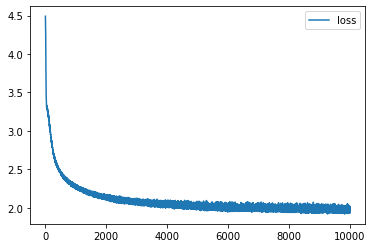

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

На этом задание завершено. Поздравляем!